# STYLE-ALIGNED WITH REFERENCE IMAGE \& CONTENT-AWARENESS  (IMG+MUSIC)

In [1]:
# Clone the repository
!git clone https://github.com/alessioborgi/StyleAligned_MultiReference-MultiModal.git

# Change directory to the cloned repository
%cd StyleAligned_MultiReference-MultiModal
%ls

# Set up Git configuration
# !git config --global user.name "Alessio Borgi"
# !git config --global user.email "alessioborgi3@gmail.com"

!git config --global user.name "Name Surname"
!git config --global user.email "email@gmail.com"

# Stage the changes
#!git add .

# Commit the changes
#!git commit -m "Added some content to your-file.txt"

# Push the changes (replace 'your-token' with your actual personal access token)
#!git push origin main

Cloning into 'StyleAligned_MultiReference-MultiModal'...
remote: Enumerating objects: 1374, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 1374 (delta 68), reused 199 (delta 64), pack-reused 1163 (from 1)
Receiving objects: 100% (1374/1374), 1.26 GiB | 17.57 MiB/s, done.
Resolving deltas: 100% (309/309), done.
Updating files: 100% (891/891), done.
/content/StyleAligned_MultiReference-MultiModal
 audio/
 imgs/
 LICENSE
 music/
 README.md
 requirements.txt
 src/
 StyleAligned_ControlNet.ipynb
 StyleAligned_Explanation.ipynb
 StyleAligned_Focused_Attention_Explanation.ipynb
 StyleAligned_Metrics.ipynb
'StyleAligned_MultiReference_Linear(3-styles).ipynb'
 StyleAligned_MultiReference_Linear.ipynb
'StyleAligned_MultiReference_Slerp(3-styles).ipynb'
 StyleAligned_MultiReference_Slerp.ipynb
 StyleAligned_MultiScale_AdaIN_Explanation.ipynb
 StyleAligned_Prompts.ipynb
'StyleAligned_Ref&Content(Audio).ipynb'
'StyleAligned_Ref

In [2]:
# Install the required packages
!pip install -r requirements.txt > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.16 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.15 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
bigframes 1.18.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
jax 0.4.33 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.4.33 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
pandas-stubs 2.1.4.231227 requires numpy>=1.26.0; python_version < "3.13", but you have numpy 1.23.5 which is incompatible.
xarray 2024.9.0 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.


In [3]:
from __future__ import annotations
import cv2
import copy
import torch
import einops
import mediapy
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
from typing import Any
from typing import Callable
from dataclasses import dataclass
from diffusers.utils import load_image
from torch.nn import functional as nnf
from diffusers.models import attention_processor
from diffusers.image_processor import PipelineImageInput
from transformers import DPTImageProcessor, DPTForDepthEstimation
from diffusers.utils.torch_utils import is_compiled_module, is_torch_version
from diffusers import StableDiffusionXLPipeline, DDIMScheduler, ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL

from src.Handler import Handler
from src.StyleAlignedArgs import StyleAlignedArgs
from src.Tokenization_and_Embedding import prompt_tokenizazion_and_embedding, embeddings_ensemble, embeddings_ensemble_with_neg_conditioning
from src.Encode_Image import image_encoding
from src.Diffusion import Generate_Noise_Prediction, Denoising_next_step, DDIM_Process, extract_latent_and_inversion, DDIM_Inversion_Process

# For the Blip model (Content Image).
import os
from transformers import BlipProcessor, BlipForConditionalGeneration

# For the Whisper model (Content Audio).
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import librosa

# For the Music Model (Content AudioMusic).
import hashlib
import torchaudio
from laion_clap import CLAP_Module

# For the Summarization and rephrasing.
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Create Alias for torch.tensor to increase readability.
T = torch.tensor
TN = T

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

#### Model Load

In [4]:
# Create a DDIMScheduler object with specific parameters
scheduler = DDIMScheduler(
    beta_start=0.00085,            # Starting value of beta for the noise schedule
    beta_end=0.012,                # Ending value of beta for the noise schedule
    beta_schedule="scaled_linear", # Type of beta schedule to use, here it is scaled linear
    clip_sample=False,             # Whether to clip the samples to a certain range
    set_alpha_to_one=False         # Whether to set alpha to one
)

# Load the Stable Diffusion XL Reference_Pipeline with a pretrained model
Reference_Pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  # Model name or path
    torch_dtype=torch.float16,                   # Data type for PyTorch tensors
    variant="fp16",                              # Variant of the model, here it is fp16 (16-bit floating point)
    use_safetensors=True,                        # Whether to use safe tensors
    scheduler=scheduler                          # Use the scheduler defined above
).to("cuda")                                     # Move the pipeline to the CUDA device (GPU)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
# 1) VanGogh Painting
# Set the source style, prompt and path.
src_style = "Van Gogh round painting"
src_prompt = f'The starry night, {src_style}.'
reference_image_path = './imgs/original.jpg'

# 2) Cubism Painting
# src_style = "cubism painting"
# src_prompt = f'Two men smoking water pipe, {src_style}.'
# reference_image_path = './imgs/Picasso_Smoking_Water_Pipe.jpeg'


# 3) Kid Drawing
# src_style = "Kid Drawing"
# src_prompt = f'A city with two houses and a church, {src_style}.'
# reference_image_path = './imgs/kid_drawing.jpeg'

# 4) Medieval Painting
# src_style = "Medieval Painting"
# src_prompt = f'Man laying in a bed, {src_style}.'
# reference_image_path = './imgs/medieval-bed.jpeg'


# Setting the number of inference steps in the Diffusion Inversion Process.
num_inference_steps = 50

# Setting the Guidance Scale for the Diffusion Inversion Process.
guidance_scale = 10.0

# 1) Normal Painting
# These are some parameters you can Adjust to Control StyleAlignment to Reference Image.
#style_alignment_score_shift = np.log(2)  # higher value induces higher fidelity, set 0 for no shift
#style_alignment_score_scale = 1.0  # higher value induces higher, set 1 for no rescale

# 2) Very Famous Paintings
style_alignment_score_shift = np.log(1)
style_alignment_score_scale = 0.5


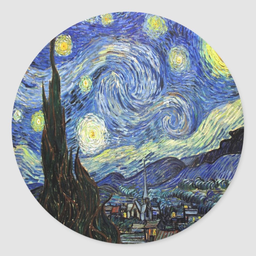

In [6]:
# Load the reference image and resize it to 1024x1024 pixels.
ref_image = np.array(load_image(reference_image_path).resize((1024, 1024)))

# Display the output image.
mediapy.show_image(ref_image, title="Reference Image for Style Alignment", height=256)

In [7]:
# Defining a type alias for the Diffusion Inversion Process type of callable.
Diff_Inversion_Process_Callback = Callable[[StableDiffusionXLPipeline, int, T, dict[str, T]], dict[str, T]]

### CONTENT IMAGE USING BLIP-1

In [8]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [9]:
def generate_description(image):
    inputs = processor(image, return_tensors="pt")
    out = model.generate(**inputs)
    description = processor.decode(out[0], skip_special_tokens=True)
    return description

In [10]:
def load_content_images(image_paths):
    """
    Load images from a list of file paths.

    Parameters:
    image_paths (List[str]): A list of file paths to the images.

    Returns:
    List[Image.Image]: A list of PIL Image objects.
    """
    content_images = []
    for img_path in image_paths:
        try:
            image = Image.open(img_path)
            content_images.append(image)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    return content_images

In [11]:
directory_path = "/content/StyleAligned_MultiReference-MultiModal/imgs/Content_Awareness/"
# set_of_images = ["skyscraper.jpeg", "PolarBear.jpeg", "cristalball.jpeg"]
set_of_images = ["tractor.jpeg", "ship.jpeg"]
set_of_images_path = [directory_path + img for img in set_of_images]
print(set_of_images_path)
content_images = load_content_images(set_of_images_path)  # Implement this as needed

['/content/StyleAligned_MultiReference-MultiModal/imgs/Content_Awareness/tractor.jpeg', '/content/StyleAligned_MultiReference-MultiModal/imgs/Content_Awareness/ship.jpeg']


In [12]:
extracted_prompts_img = [generate_description(image).strip() + "." for image in content_images]
print(extracted_prompts_img)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['a tractor ples a field.', 'a sailer in the ocean.']


### MUSIC CONTENT

In [13]:
# Function to generate a unique seed from the audio file
def generate_seed_from_audio(audio_path):
    with open(audio_path, 'rb') as f:
        audio_data = f.read()
    return int(hashlib.md5(audio_data).hexdigest(), 16) % (2**32)

# Function to generate music description based on tonal characteristics
def generate_music_description(audio_path):
    # Generate a unique seed based on the audio file
    seed = generate_seed_from_audio(audio_path)

    # Set the seed for reproducibility
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Instantiate the CLAP model
    model = CLAP_Module()

    # Load your audio file
    waveform, sample_rate = torchaudio.load(audio_path)

    # Resample if necessary (CLAP expects 48kHz)
    if sample_rate != 48000:
        resampler = torchaudio.transforms.Resample(sample_rate, 48000)
        waveform = resampler(waveform)

    # Make sure it's mono
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Ensure the tensor is on the CPU
    audio_tensor = waveform.clone().detach().cpu()

    # Tonal characteristic queries (atmospheric and descriptive)
    tonal_queries = [
        # Moods and Atmosphere
        "dark and intense", "bright and energetic", "calm and peaceful",
        "gritty and rebellious", "ethereal and dreamy", "mysterious and shadowy",
        "uplifting and inspirational", "melancholic and deep", "joyful and vibrant",
        "nostalgic and warm", "soft and serene", "fast and aggressive",
        "slow and emotional", "expansive and cinematic", "mechanical and futuristic",
        "natural and organic", "chaotic and energetic", "minimalist and clean",
        "heavy and thunderous", "grand and majestic", "smooth and jazzy",
        "vibrant and colorful", "subdued and introspective", "intense and fiery"
    ]

    # Function to get similarities
    def get_similarities(audio_tensor, queries):
        # Ensure audio tensor is on the CPU
        audio_embeddings = model.get_audio_embedding_from_data(x=audio_tensor, use_tensor=True)

        # Get text embeddings (which are already on the CPU as a NumPy array)
        text_embeddings = model.get_text_embedding(queries)

        # Convert audio embeddings to CPU if they are on GPU
        audio_embeddings = audio_embeddings.cpu()

        # Calculate similarities
        similarities = (audio_embeddings @ torch.tensor(text_embeddings).T).squeeze()
        return sorted(zip(queries, similarities), key=lambda x: x[1], reverse=True)

    # Get tonal similarities
    tonal_results = get_similarities(audio_tensor, tonal_queries)

    # Select the top tonal description
    top_tonal_description = tonal_results[0][0]

    # Generate the final tonal description
    combined_description = f"The atmosphere is {top_tonal_description}."

    print("Generated Music Description:")
    print(combined_description)

    return combined_description

In [14]:
# Generate music style prompts from the music files
music_file = "/content/StyleAligned_MultiReference-MultiModal/music/melancholic.wav"
music_style_prompt = generate_music_description(music_file)
print("Music Style Caption:", music_style_prompt)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Generated Music Description:
The atmosphere is heavy and thunderous.
Music Style Caption: The atmosphere is heavy and thunderous.


### IMG + MUSIC CONTENT

In [15]:
print(music_style_prompt)

The atmosphere is heavy and thunderous.


In [16]:
# Step 3: Combine each image description with its corresponding audio description
combined_descriptions = [
    img_desc + " " + music_style_prompt
    for img_desc in extracted_prompts_img
]

print("Non-Summarized Text: ", combined_descriptions)

Non-Summarized Text:  ['a tractor ples a field. The atmosphere is heavy and thunderous.', 'a sailer in the ocean. The atmosphere is heavy and thunderous.']


### SUMMARIZATION

In [17]:
# Load the T5 model and tokenizer
model_T5 = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer_T5 = T5Tokenizer.from_pretrained("t5-small")

# Combine the sentences (without "Summarize the phrase:" prefix)
input_text = combined_descriptions

# Function to check if a sentence is already short enough
def needs_summarization(text):
    return len(text.split()) > 15  # Adjust this threshold based on your use case

# Tokenize and generate summaries or keep original sentences if already short
summary_descriptions = []
for text in input_text:
    if needs_summarization(text):
        # Tokenize the input text
        input_ids = tokenizer_T5.encode(text, return_tensors="pt", truncation=True)

        # Generate the summary with adjusted parameters for short inputs
        summary_ids = model_T5.generate(input_ids, max_length=50, min_length=15, length_penalty=1.0, num_beams=4, early_stopping=True)

        # Decode the generated summary
        summary_text = tokenizer_T5.decode(summary_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        summary_descriptions.append(summary_text)
    else:
        # Keep the original phrase if it's already concise
        summary_descriptions.append(text)

print("Summarized Text: ", summary_descriptions)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Summarized Text:  ['a tractor ples a field. The atmosphere is heavy and thunderous.', 'a sailer in the ocean. The atmosphere is heavy and thunderous.']


In [18]:
# Set of prompts to generate images for. The first refers to the Reference Image. The other to generate images.
prompts = [
    src_prompt,  # Reference Image Prompt
    *summary_descriptions  # Prompts extracted from Img+Music
]
print(prompts)

# Append the reference style to each of subsequent prompts for generating images with the same Style.
for i in range(1, len(prompts)):
    prompts[i] = f'{prompts[i]}, {src_style}.'

# Configure the StyleAligned Handler using the StyleAlignedArgs.
handler = Handler(Reference_Pipeline)
sa_args = StyleAlignedArgs(
    share_group_norm=True,
    share_layer_norm=True,
    share_attention=True,
    adain_queries=True,
    adain_keys=True,
    adain_values=False,
    style_alignment_score_shift=style_alignment_score_shift,
    style_alignment_score_scale=style_alignment_score_scale)
handler.register(sa_args)

['The starry night, Van Gogh round painting.', 'a tractor ples a field. The atmosphere is heavy and thunderous.', 'a sailer in the ocean. The atmosphere is heavy and thunderous.']


100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


  0%|          | 0/50 [00:00<?, ?it/s]


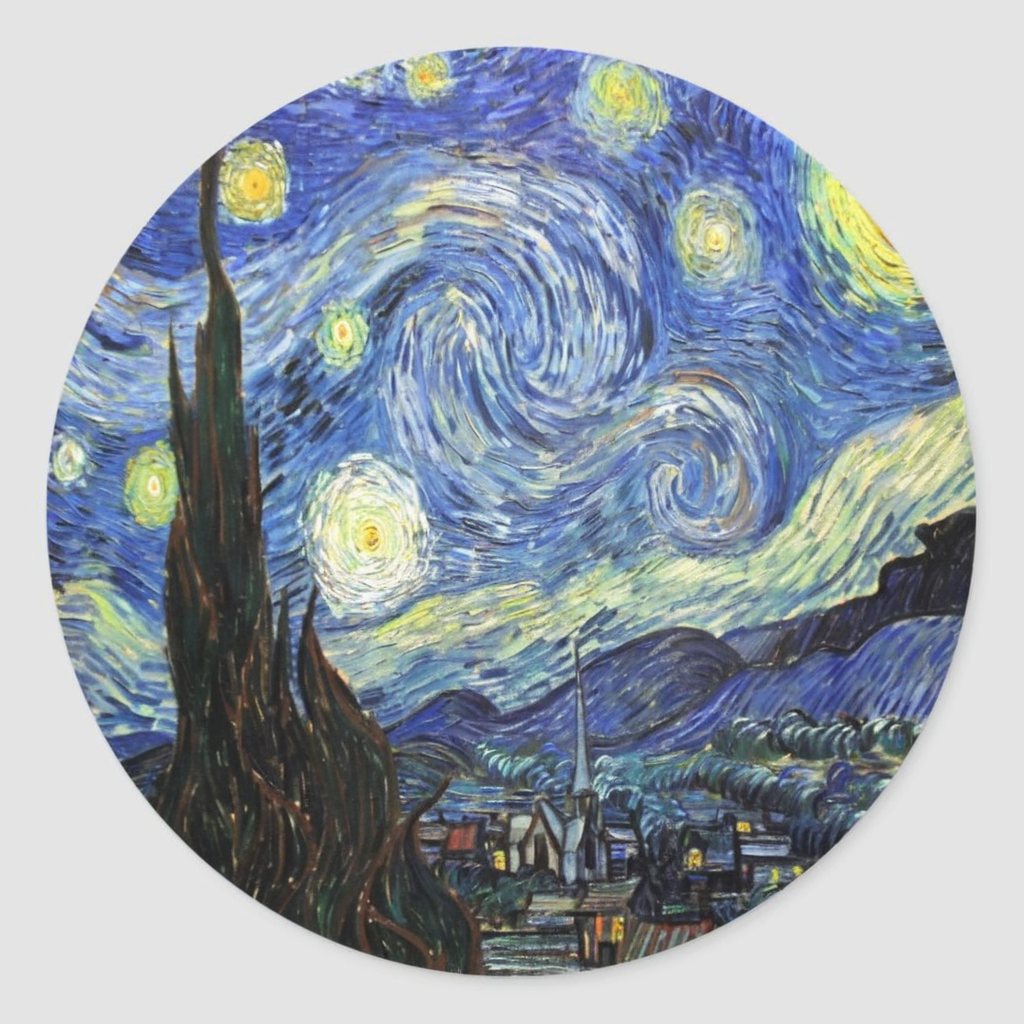
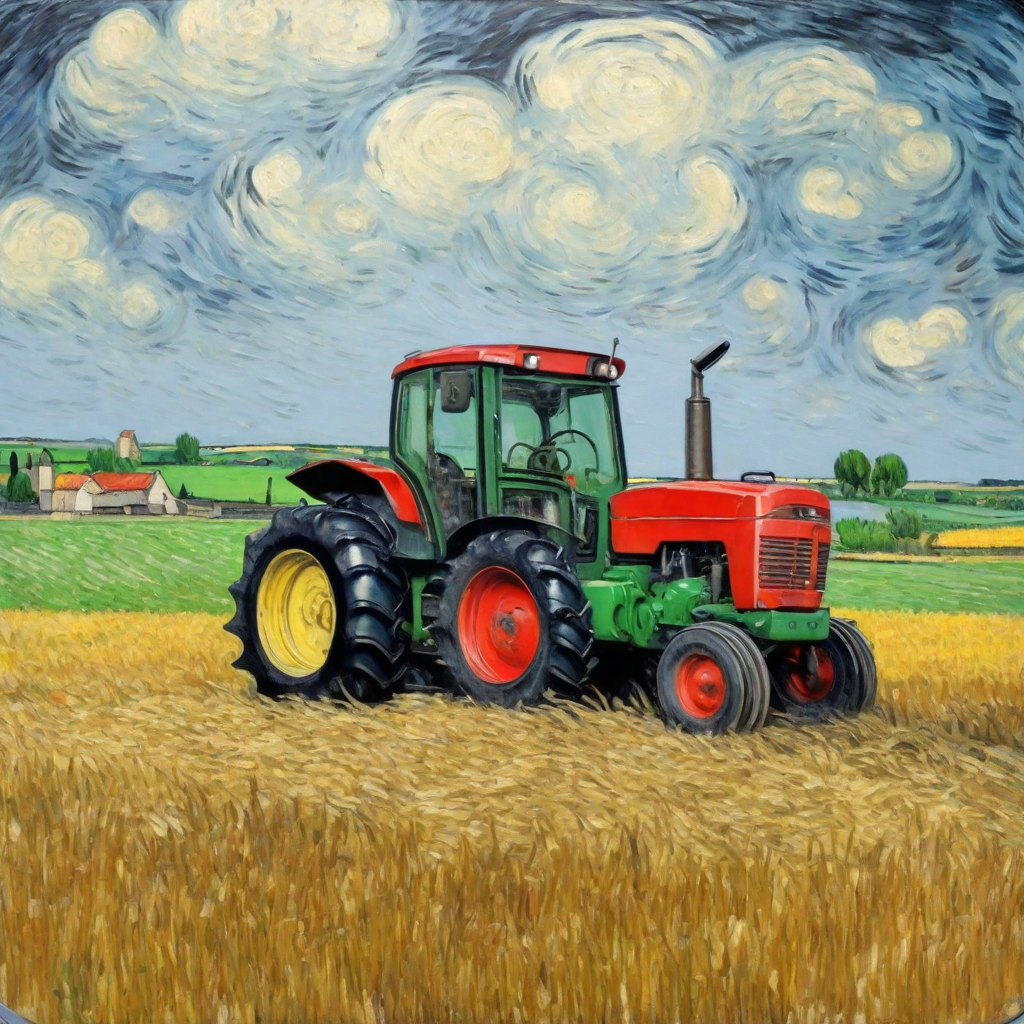
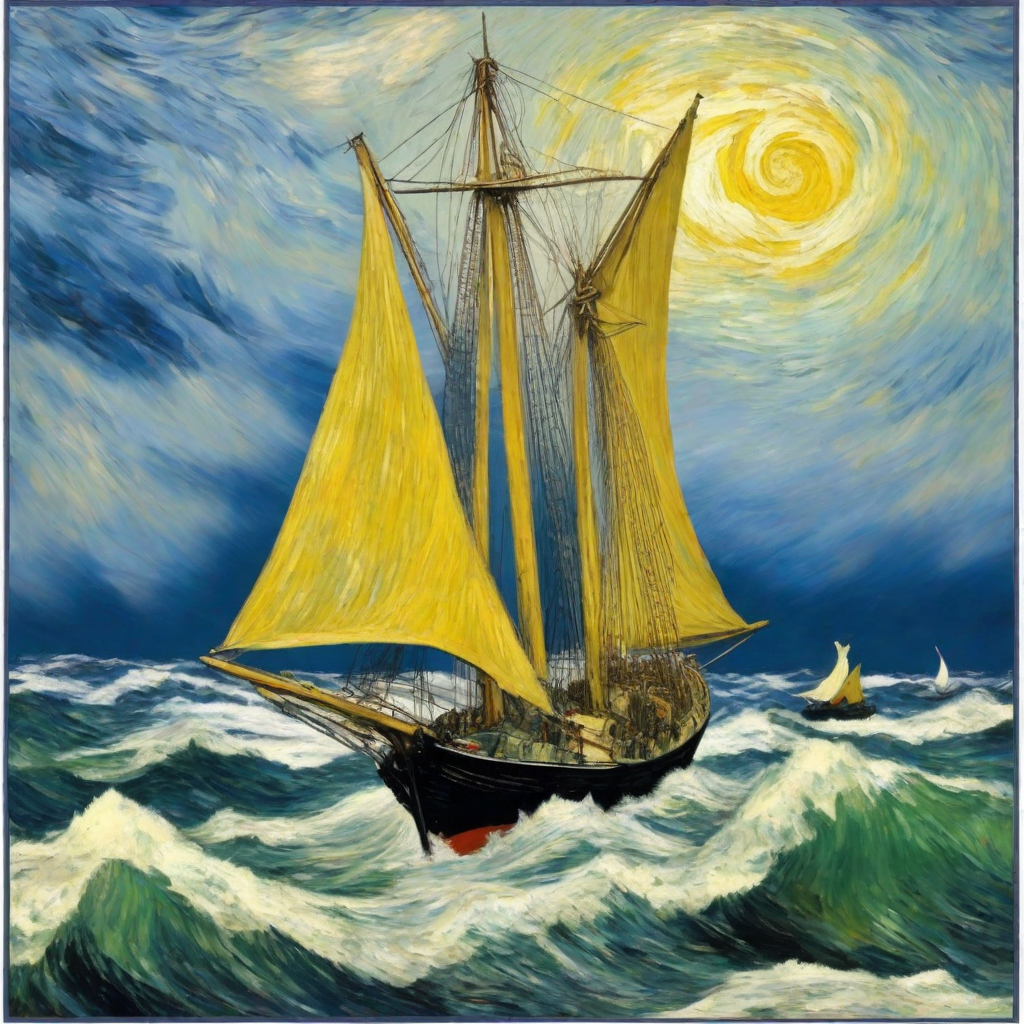

In [19]:
# Execute the Diffusion Inversion Process to map the reference image to its latent representation.
DDIM_inv_result = DDIM_Inversion_Process(Reference_Pipeline, ref_image, src_prompt, num_inference_steps, 2)

# Extract the latent representation from the Diffusion Inversion Result that can be used to guide the generation of new images in the desired style.
latent_vector_ref_img, inversion_callback = extract_latent_and_inversion(DDIM_inv_result, offset=5)

# Create a Random Number Generator on the CPU.
rand_gen = torch.Generator(device='cpu').manual_seed(10)

# Generate the images using the latent representation of the reference image as guidance.
latents = torch.randn(len(prompts), 4, 128, 128,                            # Random Latent Vectors shape
                      device='cpu',                                         # Latent Vectors on CPU.
                      generator=rand_gen,                                   # Random Number Generator.
                      dtype=Reference_Pipeline.unet.dtype,).to('cuda:0')    # Data Type of the Latent Vectors (same as required by the model's UNet).

# Set the first latent vector to the latent representation of the reference image extracted before.
latents[0] = latent_vector_ref_img

# Generate the images using the provided prompts and the latent vectors.
images_a = Reference_Pipeline(prompts,                                      # Prompts to generate images for.
                              latents=latents,                              # Latent Vectors to guide the generation of images.
                              callback_on_step_end=inversion_callback,      # Callback to update the latent vectors during the generation process.
                              num_inference_steps=num_inference_steps,      # Number of Inference Steps to generate the images.
                              guidance_scale=guidance_scale).images         # Guidance Scale to control the influence of the latent vectors on the generated images.

# Display the generated images.
handler.remove()
mediapy.show_images(images_a, titles=[p[:-(len(src_style) + 3)] for p in prompts])

In [20]:
import tensorflow as tf
import torch

def clear_gpu_memory():
    # Clear TensorFlow GPU memory
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()

    # Clear PyTorch GPU memory
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    print("GPU memory cleared.")

# Execute the function to clear GPU memory
clear_gpu_memory()


GPU memory cleared.
